In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml


In [2]:
# Load data
df = pd.read_csv('./finalalldata.csv')

# Prepare features and target
X = df.drop(columns=['label', 'uid'])
y = df['label']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numeric columns
if numeric_cols:
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Handle missing values and encode categorical columns
if categorical_cols:
    for col in categorical_cols:
        X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'missing')
    
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Ensure all columns are numeric
X = X.astype(float)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

# Create validation split from training data
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42, stratify=y_train_tensor
)

# Build datasets and loaders
train_dataset = TensorDataset(X_train_sub, y_train_sub)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [3]:

# Define dimensions
input_dim = X_train.shape[1]
hidden1_dim = input_dim 
n_qubits = 4  # Number of qubits for PQC
output_dim = 1  # Binary classification

# Create quantum device
dev = qml.device("default.qubit", wires=n_qubits)

# Define Parameterized Quantum Circuit
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    Parameterized Quantum Circuit for Binary Classification
    Args:
        inputs: classical input data (reduced dimension)
        weights: trainable quantum parameters
    """
    # Encode classical data into quantum state
    for i in range(n_qubits):
        qml.RY(inputs[i % len(inputs)], wires=i)
    
    # Parameterized quantum layers
    n_layers = weights.shape[0]
    for layer in range(n_layers):
        # Rotation gates with trainable parameters
        for i in range(n_qubits):
            qml.RY(weights[layer, i, 0], wires=i)
            qml.RZ(weights[layer, i, 1], wires=i)
        
        # Entangling gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])  # Circular entanglement
    
    # Measure expectations
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Hybrid Quantum-Classical Neural Network for Binary Classification
class QuantumBinaryNN(nn.Module):
    def __init__(self, input_dim, hidden1_dim, n_qubits, n_qlayers=2):
        super(QuantumBinaryNN, self).__init__()
        
        # Classical layers
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, n_qubits)  # Reduce to qubit dimension
        
        # Quantum layer parameters
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.q_params = nn.Parameter(torch.randn(n_qlayers, n_qubits, 2) * 0.1)
        
        # Classical output layer
        self.fc3 = nn.Linear(n_qubits, 1)  # Binary output
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()  # For quantum input encoding
        self.sigmoid = nn.Sigmoid()  # For binary classification output
        
    def forward(self, x):
        # Classical preprocessing
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.tanh(self.fc2(x))  # Normalize to [-1, 1] for quantum encoding
        
        # Quantum layer
        # Process each sample in the batch
        q_out_list = []
        for sample in x:
            q_out = quantum_circuit(sample, self.q_params)
            q_out_list.append(torch.stack(q_out))
        
        q_out_batch = torch.stack(q_out_list).float()  # Convert to float32
        
        # Classical output layer with sigmoid
        output = self.sigmoid(self.fc3(q_out_batch))
        
        return output


In [4]:

# Initialize model
model = QuantumBinaryNN(input_dim, hidden1_dim, n_qubits)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f'Model Architecture:')
print(f'Input Layer: {input_dim} neurons')
print(f'Hidden Layer 1 (Classical): {hidden1_dim} neurons')
print(f'Hidden Layer 2 (Quantum): {n_qubits} qubits')
print(f'Output Layer: {output_dim} neuron (binary classification)')
print(f'\nQuantum circuit has {model.n_qlayers} parameterized layers')
print(f'Total quantum parameters: {model.q_params.numel()}\n')


Model Architecture:
Input Layer: 15 neurons
Hidden Layer 1 (Classical): 15 neurons
Hidden Layer 2 (Quantum): 4 qubits
Output Layer: 1 neuron (binary classification)

Quantum circuit has 2 parameterized layers
Total quantum parameters: 16



In [ ]:
from tqdm import tqdm

best_val_acc = 0.0
num_epochs = 400

print("Training started...")

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    # Training loop
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        preds = (outputs >= 0.5).float()
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_acc = correct_train / total_train

    # Validate every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        for X_val_batch, y_val_batch in tqdm(val_loader, desc="Validation", leave=False):
            with torch.no_grad():
                val_out = model(X_val_batch)
                val_loss = criterion(val_out, y_val_batch)
                total_val_loss += val_loss.item()

                val_preds = (val_out >= 0.5).float()
                correct_val += (val_preds == y_val_batch).sum().item()
                total_val += y_val_batch.size(0)

        val_acc = correct_val / total_val

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"\nEpoch [{epoch+1}/{num_epochs}]"
              f" Train Loss: {avg_train_loss:.4f}"
              f" | Val Loss: {avg_val_loss:.4f}"
              f" | Train Acc: {train_acc:.4f}"
              f" | Val Acc: {val_acc:.4f}")

        # Overfitting indication
        if val_acc < train_acc:
            print("Warning: Validation accuracy lower than training accuracy → possible overfitting.")

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "quantum.pth")
            print("Model improved. Saved as quantum.pth")

# Final Test Evaluation
print("\nEvaluating best saved model on test set...")
model.load_state_dict(torch.load("quantum.pth"))
model.eval()

with torch.no_grad():
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob >= 0.5).float()
    acc = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())

print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_tensor.numpy(), y_pred.numpy(),
                            target_names=['Class 0', 'Class 1']))
print("Confusion Matrix:")
print(confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()))


In [ ]:

# Save the model
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'input_dim': input_dim,
    'hidden1_dim': hidden1_dim,
    'n_qubits': n_qubits,
    'n_qlayers': model.n_qlayers,
    'accuracy': acc
}

torch.save(save_dict, 'quantum_binary_model.pth')
print('\nModel saved to: quantum_binary_model.pth')

# Visualize quantum circuit
print(f'\nQuantum Circuit Structure:')
print(qml.draw(quantum_circuit)(torch.randn(n_qubits), model.q_params))

In [5]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load best saved model
model.load_state_dict(torch.load("quantum.pth"))
model.eval()

total_val_loss = 0
correct_val = 0
total_val = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for X_val_batch, y_val_batch in val_loader:
        val_out = model(X_val_batch)
        val_loss = criterion(val_out, y_val_batch)
        total_val_loss += val_loss.item()

        val_preds = (val_out >= 0.5).float()
        
        all_preds.extend(val_preds.cpu().numpy())
        all_targets.extend(y_val_batch.cpu().numpy())

        correct_val += (val_preds == y_val_batch).sum().item()
        total_val += y_val_batch.size(0)

avg_val_loss = total_val_loss / len(val_loader)
val_acc = correct_val / total_val

print("\n===== VALIDATION RESULTS =====")
print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=['Class 0', 'Class 1']))

print("Confusion Matrix:")
print(confusion_matrix(all_targets, all_preds))



===== VALIDATION RESULTS =====
Validation Loss: 0.4949
Validation Accuracy: 0.8725

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.68      0.76        31
     Class 1       0.87      0.96      0.91        71

    accuracy                           0.87       102
   macro avg       0.87      0.82      0.84       102
weighted avg       0.87      0.87      0.87       102

Confusion Matrix:
[[21 10]
 [ 3 68]]



===== VALIDATION RESULTS =====
Validation Loss: 0.4949
Validation Accuracy: 0.8725

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.68      0.76        31
     Class 1       0.87      0.96      0.91        71

    accuracy                           0.87       102
   macro avg       0.87      0.82      0.84       102
weighted avg       0.87      0.87      0.87       102



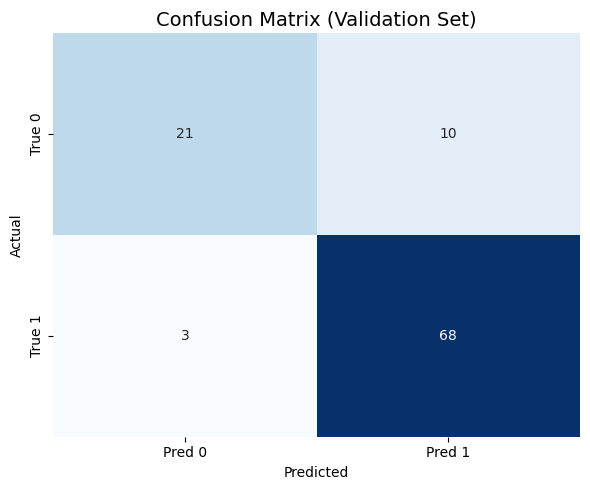

In [6]:

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Load best model
# ------------------------------
model.load_state_dict(torch.load("quantum.pth"))
model.eval()

total_val_loss = 0
correct_val = 0
total_val = 0

all_preds = []
all_targets = []

# ------------------------------
# Run evaluation
# ------------------------------
with torch.no_grad():
    for X_val_batch, y_val_batch in val_loader:
        val_out = model(X_val_batch)
        val_loss = criterion(val_out, y_val_batch)
        total_val_loss += val_loss.item()

        val_preds = (val_out >= 0.5).float()

        all_preds.extend(val_preds.cpu().numpy())
        all_targets.extend(y_val_batch.cpu().numpy())

        correct_val += (val_preds == y_val_batch).sum().item()
        total_val += y_val_batch.size(0)

# ------------------------------
# Metrics
# ------------------------------
avg_val_loss = total_val_loss / len(val_loader)
val_acc = correct_val / total_val
cm = confusion_matrix(all_targets, all_preds)

print("\n===== VALIDATION RESULTS =====")
print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=['Class 0', 'Class 1']))

# ------------------------------
# Nicely formatted confusion matrix plot
# ------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1']
)
plt.title("Confusion Matrix (Validation Set)", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
